**This Notebook contains functions to monitor the models that we retrain every week for predicting passage likelihood** 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import yaml

from triage.component.postmodeling.contrast.utils.aux_funcs import get_models_ids

from src.utils.general import get_db_conn
from src.utils import project_constants as constants
from src.bill_passage.postmodeling.model_evaluator import ModelEvaluatorACLU
from sklearn import metrics
from triage.component.catwalk.storage import ProjectStorage
from triage.component.timechop import Timechop
from src.utils.visualize_timechop import visualize_chops

#### Connections

In [3]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file, conn_type='sqlalchemy')

project_path = 's3://aclu-leg-tracker/experiment_data/bill_passage/predict_forward'

config_file = '../src/bill_passage/predict_forward/last_used_config.yaml'

### Things we can monitor for:

- Data -- For data, we should have a prior about the distribution of activity at the same time in the previous years. Then we could compare the activity in the current week to that and see whether it follows the same trend.
    - num states active
    - num of new bills
- Models
    - performance (we need a validation split in the predict forward setup)
    - num of bills in each passage category
    - crosstabs
    - score distribution
    - feature importances

#### We need to fetch the experiment hash, and other information

We use a specific model comment---_"predict_forward_lt"_---to distinguish predict forward experiments from others. We assume experiment hash corresponding to the last completed predict forward run is the experiment hash we need

## 1. Experiment

##### 1.1 Experiment Hash

In [4]:
q = """
    select 
        experiment_hash, 
        to_char(start_time, 'YYYY-MM-DD') as run_date,
        to_char(start_time - '1w'::interval, 'YYYY-MM-DD') as week_start
    from triage_metadata.experiments join triage_metadata.experiment_runs using(experiment_hash)
    where config->>'model_comment' = 'predict_forward_lt' and current_status='completed'
    order by start_time desc limit 1
"""

experiment = pd.read_sql(q, db_conn).to_dict('records')[0]
experiment

{'experiment_hash': 'e743816a5c6d5a3e5dd2d6777af47e7d',
 'run_date': '2021-10-03',
 'week_start': '2021-09-26'}

##### 1.2 Temporal Config

In [5]:
q = """
    select 
        config->>'temporal_config' as temporal_config
    from triage_metadata.experiments
    where experiment_hash='{}'
""".format(experiment['experiment_hash'])

temporal_config = yaml.safe_load(pd.read_sql(q, db_conn).at[0, 'temporal_config'])

chopper = Timechop(**temporal_config)

visualize_chops(
    chopper=chopper,
    show_as_of_times=True,
    show_boundaries=True
)

##### 1.3 Model and Matrices

In [6]:
q = """
    select
        model_id,
        model_group_id,
        model_hash,
        train_matrix_uuid,
        matrix_uuid as test_matrix_uuid,
        train_end_time
    from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
        join test_results.prediction_metadata using(model_id)
    where experiment_hash='{}'
""".format(experiment['experiment_hash'])

models = pd.read_sql(q, db_conn).to_dict('records')[0]
models

{'model_id': 17840,
 'model_group_id': 728,
 'model_hash': '596af3e2541049fca879d4e00447d770',
 'train_matrix_uuid': '94a7c19fd774d9d246b87ef79d046cbe',
 'test_matrix_uuid': '064796945b16637d35e05233ad905e06',
 'train_end_time': Timestamp('2021-10-03 00:00:00')}

## 2. Data

In [7]:
# we have to load the matrix
project_storage = ProjectStorage(project_path)
matrix_storage_engine = project_storage.matrix_storage_engine()

test_mat_store = matrix_storage_engine.get_store(matrix_uuid=models['test_matrix_uuid'])
test_matrix = test_mat_store.matrix_label_tuple[0].reset_index()

2021-10-05 21:01:34 -    INFO Found credentials in shared credentials file: ~/.aws/credentials


##### 2.1 How many bills did we score (active bills)?

In [8]:
q = "select num_observations from triage_metadata.matrices where matrix_uuid='{}'".format(models['test_matrix_uuid'])
num_bills_scored = pd.read_sql(q, db_conn).at[0, 'num_observations']
num_bills_scored

4393

##### 2.2 What are the states are present (in session) in the predict forward set?

In [9]:
# The state is used as a dummyfied categorical
state_cols = [x for x in test_matrix if 'state' in x]
states_present = test_matrix[state_cols].sum().sort_values(ascending=False)
states = [x.split('_')[-2] for x in states_present[states_present>0].index]
print(sorted(states))

['AK', 'AR', 'CA', 'IL', 'MA', 'ME', 'MI', 'NC', 'NE', 'NH', 'NY', 'OH', 'PA', 'TN', 'WI']


##### 2.2.1 Let's compare the states in regular session over the years

In [10]:
q = """
    select 
        session_year,
        b.state_abbreviation as state,
        case 
            when 
                '{as_of_date}'::date 
                between ('{current_year}'::text || '-' || to_char(convene_date, 'MM-DD'))::date 
                and ('{current_year}'::text || '-' ||to_char(adjourn_date, 'MM-DD'))::date
            then 1 
            when 
                '{as_of_date}'::date > ('{current_year}'::text || '-' || to_char(convene_date, 'MM-DD'))::date
                and adjourn_date is null
            then 1
            else 0 
        end as in_session
    --from pre_triage_features.ajusted_session_dates a join catalogs.states b on a.state_name=b.state 
    from clean.ncsl_legiscan_linked a join catalogs.states b on a.state_name=b.state 
    where session_year < {current_year}
""".format(
    as_of_date=experiment['run_date'],
    current_year=2021
)

states_in_session_history = pd.read_sql(q, db_conn)

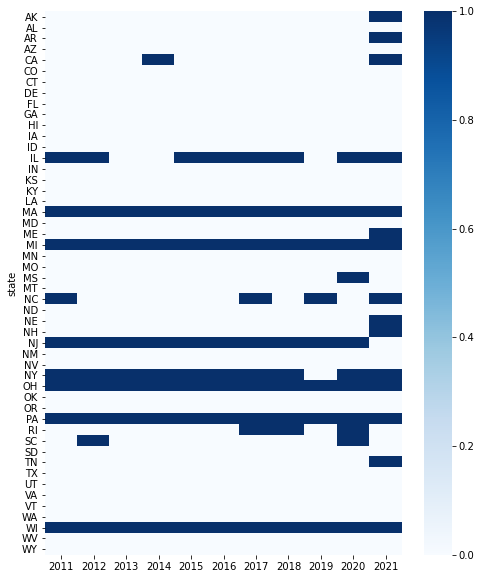

In [11]:
%matplotlib inline
temp = states_in_session_history.pivot("state", "session_year", "in_session")

this_year = {x: 1 for x in states}
this_year = pd.Series(this_year)
this_year.name=2021
temp = temp.join(this_year).fillna(0)

fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(temp, xticklabels=True, yticklabels=True, cbar=True, cmap="Blues", square=False)

##### 2.3 how many bills were introduced in the last week?

In [12]:
bill_age_feature = 'bl_pf_entity_id_all_bill_age_max'
msk = test_matrix[bill_age_feature] < 7
num_new_bills = test_matrix[msk].shape[0]
num_new_bills

268

##### 2.3.1 Let's compare that to the previous years

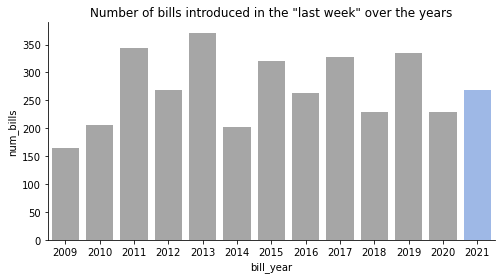

In [13]:
q = """
    select 
        date_part('year', introduced_date)::int as bill_year,
        min(introduced_date) as oldest_bill,
        max(introduced_date) as latest_bill,
        count(distinct bill_id)	as num_bills
    from clean.bills join clean.sessions using(session_id) join catalogs.states using(state_id)
    where 
    introduced_date BETWEEN 
    (date_part('year', introduced_date)::text || '-' || to_char('{range_start_date}'::date, 'MM-DD'))::date AND 
    (date_part('year', introduced_date)::text || '-' || to_char('{range_end_date}'::date, 'MM-DD'))::date
    and date_part('year', introduced_date)::int < date_part('year', '{range_start_date}'::date)::int
    and not special
    group by 1
""".format(
    range_start_date=experiment['week_start'],
    range_end_date=experiment['run_date']
)
bills_in_the_same_period = pd.read_sql(q, db_conn)
this_year = {'bill_year':2021, 'range_start': experiment['week_start'], 'range_end': experiment['run_date'], 'num_bills': num_new_bills}
temp = bills_in_the_same_period.append(this_year, ignore_index=True)

fig, ax = plt.subplots(figsize=(8, 4))
colors = ['cornflowerblue' if x['bill_year']==2021 else 'gray' for i,x in temp.iterrows()]
sns.barplot(y='num_bills', x='bill_year', data=temp, palette=colors, alpha=0.7, ax=ax)
ax.set_title('Number of bills introduced in the "last week" over the years')
sns.despine()

## 3.Models

In [14]:
model_evaluator = ModelEvaluatorACLU(
    model_group_id=models['model_group_id'],
    model_id=models['model_id'],
    engine=db_conn
)
model_evaluator.pred_matrix_uuid

'064796945b16637d35e05233ad905e06'

##### 3.1 Score distribution

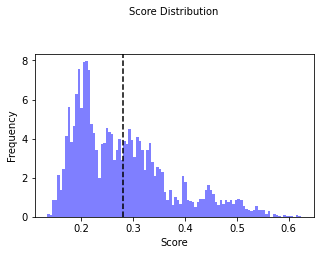

In [15]:
model_evaluator.plot_score_distribution(nbins=100, figsize=(5,3), fontsize=10)

##### 3.2 Passage Categories

In [20]:
categories = {
    '6-will_not_pass': [0, 0.10],
    '5-unlikely': [0.10, 0.35],
    '4-could go either way': [0.35, 0.55],
    '3-likely': [0.55, 0.70],
    '2-very_likely': [0.70, 0.90],
    '1-will_pass': [0.90, 1.1]
}

preds = model_evaluator.predictions
preds['passage_category'] = None
for category, bounds in categories.items():
    msk = (preds['score'] >= bounds[0]) & (preds['score'] < bounds[1]) 
    preds.loc[msk, 'passage_category'] = category

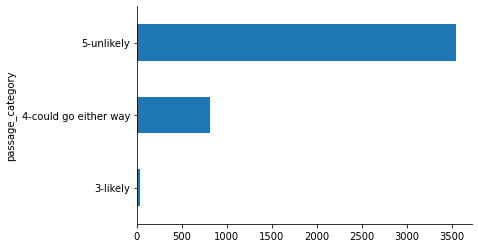

In [21]:
preds.groupby('passage_category').count()['entity_id'].plot(kind='barh')
sns.despine()

##### 3.3 feature importances

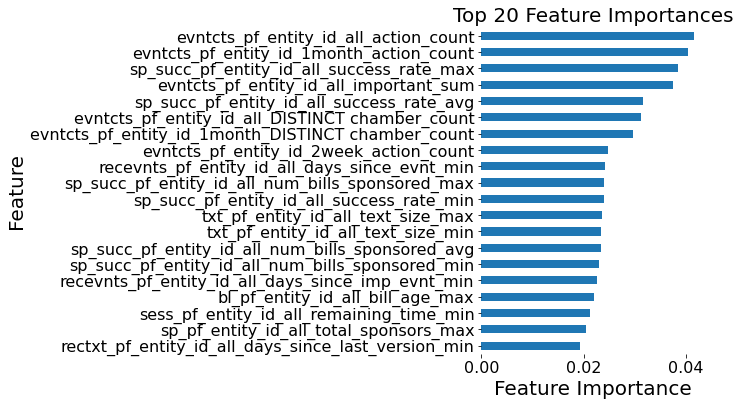

In [23]:
model_evaluator.plot_feature_importances(path=None, figsize=(4, 6), fontsize=20,n_features_plots=20)

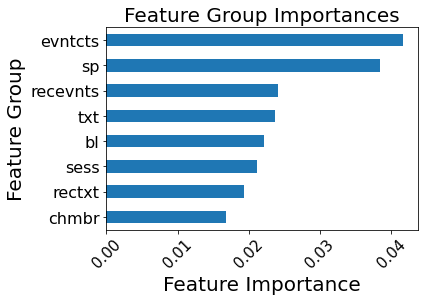

In [24]:
model_evaluator.plot_feature_group_aggregate_importances(path=None, figsize=(6, 4), fontsize=20)